In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import math
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import r2_score

import sys
sys.path.insert(0, os.path.abspath('../Libraries'))
import countries as cLib
from countries import get_alpha_2_list, get_alpha_3_list

In [2]:
tsv_file='../Datasets/tesem220_tabular.tsv'
 
df=pd.read_table(tsv_file,sep='\t')
df

,"freq,geo\TIME_PERIOD",2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"A,AT",83.00,82.90,82.40,81.70,79.90,80.40,74.80,74.80,74.60,74.3,73.90,72.00,72.1,71.7,71.2,70.50,70.10
1,"A,BE",85.20,84.90,85.30,85.50,92.10,91.00,90.70,91.90,98.10,97.6,96.90,95.80,95.8,93.8,93.0,92.40,91.60
2,"A,BG",:,:,:,76.70,81.70,80.90,81.60,81.60,81.60,81.6,81.60,81.60,82.0,82.4,82.4,82.40,82.40
3,"A,CH",77.70,77.40,77.60,78.90,78.50,78.50,78.50,78.20,78.50,78.3,78.70,78.30,77.1,77.2,77.6,78.90,80.10
4,"A,CY",62.70,62.50,62.40,:,:,:,:,:,:,64.3,:,:,64.2,64.0,64.4,64.40,64.10
5,"A,CZ",65.70,63.50,59.90,59.60,71.30,71.40,71.70,71.60,71.60,71.7,71.80,72.00,72.3,72.5,72.7,72.80,70.80
6,"A,DE",75.00,75.60,74.80,74.50,75.20,73.50,73.30,73.30,73.00,73.1,73.10,73.20,73.3,73.2,73.2,73.00,72.80
7,"A,DK",91.20,90.60,89.50,88.60,88.80,89.20,88.70,89.40,89.40,89.6,89.60,89.80,89.9,89.3,88.4,87.90,87.20
8,"A,EA19",78.8,78.9,76.9,77.4,77.7,76.8,76.8,76.8,77.1,77.1,77.0,76.8,76.6,76.4,75.8,75.4,75.9
9,"A,EE",64.30,63.50,63.00,62.60,61.90,62.70,63.50,64.30,63.70,63.7,62.90,62.90,62.9,61.5,62.2,62.50,69.30


In [3]:
# Clean the dataset

# Replace ":" with NaN
df_cleaned = df.copy()
for index, row in df_cleaned.iterrows():
    for column in df_cleaned.columns[1:]:
        try:
            row[column] = float(row[column])
        except:
            df_cleaned.at[index, column] = np.NaN


# If there are 3 or less consecutive missing values, use Linear Interpolation to fill the missing values
# If there are more than 3 consecutive missing values, drop the row
df_cleaned.interpolate(method='linear', inplace=True, limit=3)
df_cleaned.dropna(inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)

df_cleaned.rename(columns={'freq,geo\TIME_PERIOD': 'COUNTRY'}, inplace=True)
df_cleaned.rename(columns=lambda x: int(x.strip()) if x != "COUNTRY" else x, inplace=True)
df_cleaned['COUNTRY'] = df_cleaned['COUNTRY'].str.split(',').str[1]

for column in df_cleaned.columns[1:]:
    df_cleaned[column] = df_cleaned[column].astype(float)
df_cleaned

,COUNTRY,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AT,83.0,82.9,82.4,81.7,79.9,80.4,74.8,74.8,74.6,74.3,73.9,72.0,72.1,71.7,71.2,70.5,70.1
1,BE,85.2,84.9,85.3,85.5,92.1,91.0,90.7,91.9,98.1,97.6,96.9,95.8,95.8,93.8,93.0,92.4,91.6
2,CH,77.7,77.4,77.6,78.9,78.5,78.5,78.5,78.2,78.5,78.3,78.7,78.3,77.1,77.2,77.6,78.9,80.1
3,CZ,65.7,63.5,59.9,59.6,71.3,71.4,71.7,71.6,71.6,71.7,71.8,72.0,72.3,72.5,72.7,72.8,70.8
4,DE,75.0,75.6,74.8,74.5,75.2,73.5,73.3,73.3,73.0,73.1,73.1,73.2,73.3,73.2,73.2,73.0,72.8
5,DK,91.2,90.6,89.5,88.6,88.8,89.2,88.7,89.4,89.4,89.6,89.6,89.8,89.9,89.3,88.4,87.9,87.2
6,EA19,78.8,78.9,76.9,77.4,77.7,76.8,76.8,76.8,77.1,77.1,77.0,76.8,76.6,76.4,75.8,75.4,75.9
7,EE,64.3,63.5,63.0,62.6,61.9,62.7,63.5,64.3,63.7,63.7,62.9,62.9,62.9,61.5,62.2,62.5,69.3
8,EL,55.4,56.4,59.1,65.5,65.4,51.5,56.8,50.7,50.6,50.5,50.3,52.5,52.6,52.6,52.3,55.8,53.7
9,ES,80.2,80.3,81.5,81.2,80.6,82.6,82.7,82.8,81.7,81.7,81.2,81.1,81.1,81.9,82.0,80.5,82.1


In [4]:
# Get only the countries in the EU
df_eu = df_cleaned[df_cleaned['COUNTRY'].isin(get_alpha_2_list())]
df_eu.reset_index(drop=True, inplace=True)
df_eu.to_csv('../Datasets/cleaned_unemploymentTaxRateDataset.csv', index=False)
df_eu

,COUNTRY,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AT,83.0,82.9,82.4,81.7,79.9,80.4,74.8,74.8,74.6,74.3,73.9,72.0,72.1,71.7,71.2,70.5,70.1
1,BE,85.2,84.9,85.3,85.5,92.1,91.0,90.7,91.9,98.1,97.6,96.9,95.8,95.8,93.8,93.0,92.4,91.6
2,CH,77.7,77.4,77.6,78.9,78.5,78.5,78.5,78.2,78.5,78.3,78.7,78.3,77.1,77.2,77.6,78.9,80.1
3,CZ,65.7,63.5,59.9,59.6,71.3,71.4,71.7,71.6,71.6,71.7,71.8,72.0,72.3,72.5,72.7,72.8,70.8
4,DE,75.0,75.6,74.8,74.5,75.2,73.5,73.3,73.3,73.0,73.1,73.1,73.2,73.3,73.2,73.2,73.0,72.8
5,DK,91.2,90.6,89.5,88.6,88.8,89.2,88.7,89.4,89.4,89.6,89.6,89.8,89.9,89.3,88.4,87.9,87.2
6,EE,64.3,63.5,63.0,62.6,61.9,62.7,63.5,64.3,63.7,63.7,62.9,62.9,62.9,61.5,62.2,62.5,69.3
7,ES,80.2,80.3,81.5,81.2,80.6,82.6,82.7,82.8,81.7,81.7,81.2,81.1,81.1,81.9,82.0,80.5,82.1
8,FI,77.8,76.3,74.0,73.1,72.1,72.3,72.3,75.0,75.6,81.7,79.2,78.3,74.4,73.9,73.4,73.1,72.4
9,FR,81.6,80.8,77.4,77.2,77.2,76.9,77.4,77.3,77.3,77.4,76.5,76.5,75.8,75.1,72.6,72.2,72.7


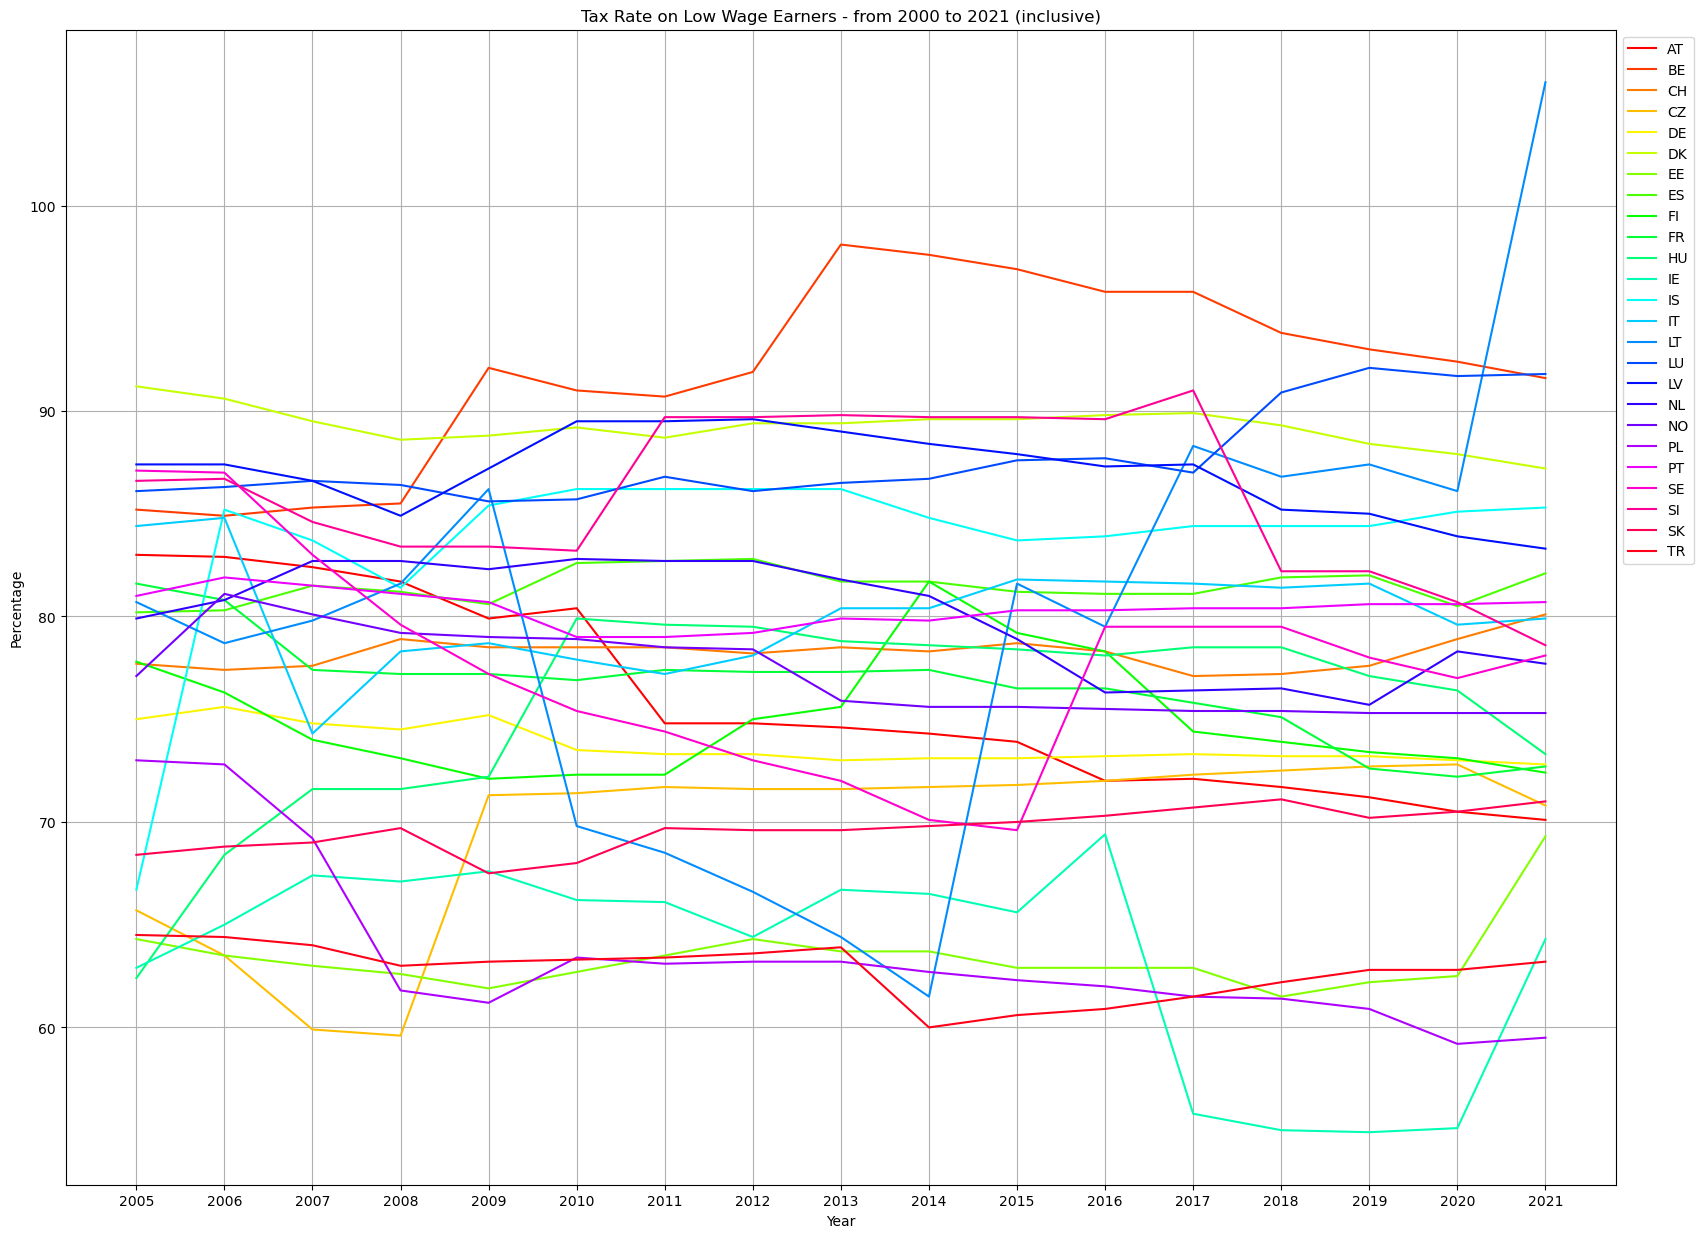

In [5]:
# Plot the tax rate for each country
plt.figure(figsize=(20, 15))

colors = plt.cm.hsv(np.linspace(0, 1, df_eu.shape[0]))
country_codes = df_eu['COUNTRY']
years = df_eu.keys()[1:]
years_xticks = [int(year) for year in years]

for i in range(len(country_codes)):
    country_code = country_codes[i]
    # Plot years to Value
    plt.plot(years, df_eu.loc[i, years], color=colors[i], label=country_code)

plt.grid()
plt.xticks(years_xticks)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
plt.xlabel('Year') 
plt.ylabel('Percentage')
plt.title("Tax Rate on Low Wage Earners - from 2000 to 2021 (inclusive)")
plt.show()

In [6]:
# Get the mean unemployment tax rate
df_eu_mean = df_eu.mean(numeric_only=True, axis=0)
df_eu_mean = df_eu_mean.to_frame().T
df_eu_mean

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,77.196,78.204,77.18,76.588,77.4,77.108,77.12,77.14,77.264,76.988,77.496,77.676,77.364,76.84,76.58,76.244,77.484


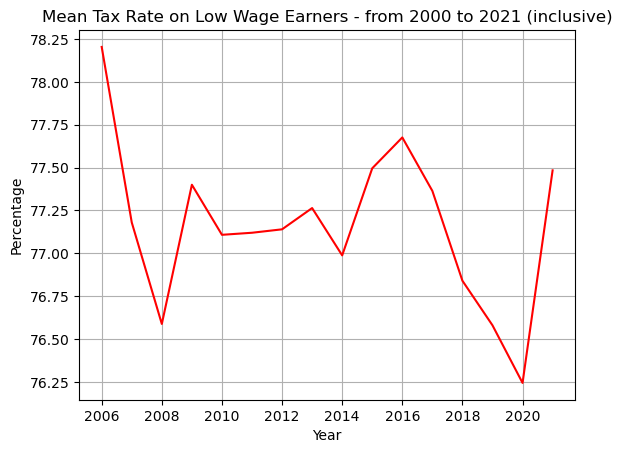

In [7]:
plt.plot(df_eu_mean.keys()[1:], df_eu_mean.values[0][1:], color="r")
plt.grid()
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title("Mean Tax Rate on Low Wage Earners - from 2000 to 2021 (inclusive)")
plt.show()

As seen in the graph above, tax rate on unemployment dropped significantly for 2008 and 2020

## Comparison of Tax Rate on Low Wage Earners and Labour Productivity

In [8]:
path = "../Datasets/cleaned_Productivity.csv"
df_labour = pd.read_csv(path)
df_labour.rename(columns=lambda x: int(x) if x.isdigit() else x, inplace=True)
df_labour.drop(columns=['mean'], inplace=True)
df_labour.head()

,LOCATION,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AUS,43.813437,45.338482,46.025462,47.089456,46.931496,47.099677,47.342066,47.873036,49.523676,...,51.671243,52.558753,52.780926,54.099648,53.945416,54.561035,54.559641,55.212012,56.214321,56.820351
1,AUT,55.825179,56.533555,57.591558,58.071618,59.181589,60.632340,62.218785,63.814049,63.814456,...,65.645538,66.080679,66.327394,67.267651,67.184974,67.999464,68.309455,68.309868,69.970148,69.634603
2,BEL,63.089170,63.233672,63.667303,64.204011,66.278551,67.287921,67.637137,68.887444,68.464336,...,68.923207,69.517696,70.513657,71.604653,71.674769,71.534022,71.681631,72.259271,74.541737,73.607184
3,BGR,14.861829,15.438275,16.313284,16.783858,17.182034,17.965425,18.618248,19.229785,19.475667,...,22.497211,22.460713,22.607390,23.296069,23.897609,24.130056,24.784139,25.687153,25.775778,26.559335
4,CAN,44.249048,44.960465,45.686833,45.787448,46.167149,47.187987,47.742663,47.802103,47.658733,...,49.335662,50.068609,51.425818,51.340885,51.524774,52.346352,52.543577,52.996192,56.971404,53.969872


In [9]:
df_labour = df_labour[df_labour['LOCATION'].isin(get_alpha_3_list())]
df_labour.reset_index(drop=True, inplace=True)
df_labour.head()

,LOCATION,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AUT,55.825179,56.533555,57.591558,58.071618,59.181589,60.632340,62.218785,63.814049,63.814456,...,65.645538,66.080679,66.327394,67.267651,67.184974,67.999464,68.309455,68.309868,69.970148,69.634603
1,BEL,63.089170,63.233672,63.667303,64.204011,66.278551,67.287921,67.637137,68.887444,68.464336,...,68.923207,69.517696,70.513657,71.604653,71.674769,71.534022,71.681631,72.259271,74.541737,73.607184
2,BGR,14.861829,15.438275,16.313284,16.783858,17.182034,17.965425,18.618248,19.229785,19.475667,...,22.497211,22.460713,22.607390,23.296069,23.897609,24.130056,24.784139,25.687153,25.775778,26.559335
3,CHE,61.437020,62.847795,63.171539,62.871440,63.236690,64.693828,66.315161,67.595243,68.253612,...,68.494780,69.759903,70.447419,69.982344,70.431631,71.561236,73.212853,73.619376,74.655861,75.909195
4,CZE,25.998047,27.994158,28.429678,29.901424,31.147574,32.765277,34.781571,36.256014,36.139167,...,36.886973,37.004724,37.432375,39.390083,39.251558,40.595969,41.161265,42.272668,43.289836,43.487932


In [10]:
# As Labour Productivity dataset uses alpha-3, we need to convert the alpha-2 to alpha3
df_eu_alpha3 = df_eu.copy()
for index, row in df_eu.iterrows():
    df_eu_alpha3.at[index, 'COUNTRY'] = cLib.convert_alpha_2_to_3(row['COUNTRY'])
df_eu_alpha3

,COUNTRY,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AUT,83.0,82.9,82.4,81.7,79.9,80.4,74.8,74.8,74.6,74.3,73.9,72.0,72.1,71.7,71.2,70.5,70.1
1,BEL,85.2,84.9,85.3,85.5,92.1,91.0,90.7,91.9,98.1,97.6,96.9,95.8,95.8,93.8,93.0,92.4,91.6
2,CHE,77.7,77.4,77.6,78.9,78.5,78.5,78.5,78.2,78.5,78.3,78.7,78.3,77.1,77.2,77.6,78.9,80.1
3,CZE,65.7,63.5,59.9,59.6,71.3,71.4,71.7,71.6,71.6,71.7,71.8,72.0,72.3,72.5,72.7,72.8,70.8
4,DEU,75.0,75.6,74.8,74.5,75.2,73.5,73.3,73.3,73.0,73.1,73.1,73.2,73.3,73.2,73.2,73.0,72.8
5,DNK,91.2,90.6,89.5,88.6,88.8,89.2,88.7,89.4,89.4,89.6,89.6,89.8,89.9,89.3,88.4,87.9,87.2
6,EST,64.3,63.5,63.0,62.6,61.9,62.7,63.5,64.3,63.7,63.7,62.9,62.9,62.9,61.5,62.2,62.5,69.3
7,ESP,80.2,80.3,81.5,81.2,80.6,82.6,82.7,82.8,81.7,81.7,81.2,81.1,81.1,81.9,82.0,80.5,82.1
8,FIN,77.8,76.3,74.0,73.1,72.1,72.3,72.3,75.0,75.6,81.7,79.2,78.3,74.4,73.9,73.4,73.1,72.4
9,FRA,81.6,80.8,77.4,77.2,77.2,76.9,77.4,77.3,77.3,77.4,76.5,76.5,75.8,75.1,72.6,72.2,72.7


In [11]:
# Get the mean labour productivity
df_labour_mean = df_labour.mean(numeric_only=True, axis=0)
df_labour_mean = df_labour_mean.to_frame().T
df_labour_mean

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,42.304295,43.117648,44.129809,45.149761,46.476494,47.519574,48.69278,49.803404,49.463907,48.971812,...,51.109385,51.629951,52.102305,53.353654,53.638816,54.708595,55.388139,56.138822,57.752927,58.478982


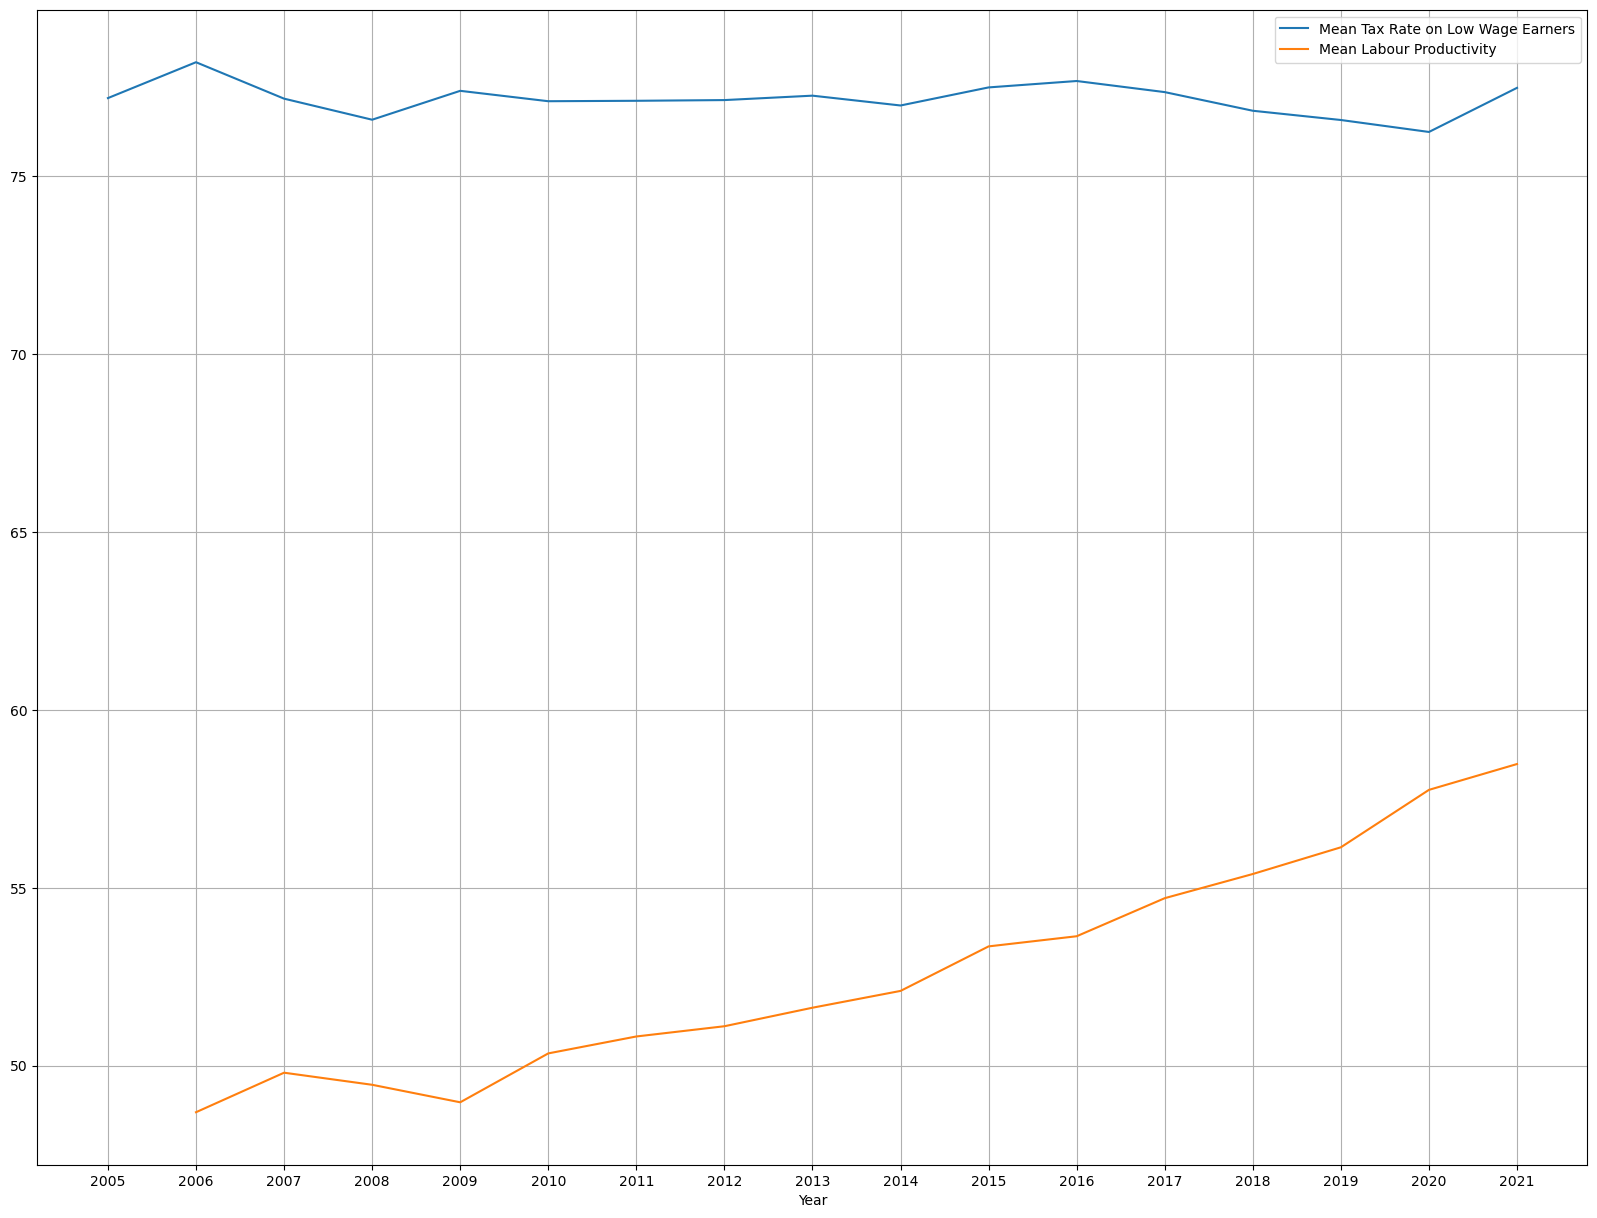

In [12]:
# Plot the mean tax rate and mean labour productivity together
plt.figure(figsize=(20, 15))
plt.plot(years, df_eu_mean.values[0], label="Mean Tax Rate on Low Wage Earners")
plt.plot(df_labour_mean.keys()[6:], df_labour_mean.values[0][6:], label="Mean Labour Productivity")
plt.grid()
plt.legend()
plt.xlabel('Year')
plt.xticks(years_xticks)
plt.show()

In [13]:
# Uneven number of country codes, so get the fewest number of country codes
arr1 = [cd for cd in df_eu_alpha3['COUNTRY']]
arr2 = [cd for cd in df_labour['LOCATION']]
country_codes = arr1 if len(arr1) < len(arr2) else arr2

In [14]:
# Join tables together
df_countries = pd.DataFrame(columns=['Year', 'Country', 'Labour Productivity', 'Tax Rate'])
for i in range(len(country_codes)):
    tmp_dict = {}
    countryCode = country_codes[i]
    for year in years:
        tmp_dict[year] = [df_labour.loc[i, year], df_eu_alpha3.loc[i, year]]
    df_country = pd.DataFrame.from_dict(tmp_dict, orient='index', columns=['Labour Productivity', 'Tax Rate'])
    df_country['Year'] = df_country.index
    df_country['Country'] = countryCode

    df_countries = pd.concat([df_countries, df_country], axis=0)
df_countries.reset_index(drop=True, inplace=True)

In [15]:
# Look at correlation between labour productivity and tax rate on low wage earners
df_correlation = df_countries.groupby(df_countries['Country']).corr(numeric_only=True)
df_correlation

Labour Productivity  Tax Rate
Country                                                   
AUT     Labour Productivity             1.000000 -0.944059
        Tax Rate                       -0.944059  1.000000
BEL     Labour Productivity             1.000000  0.538396
        Tax Rate                        0.538396  1.000000
CHE     Labour Productivity             1.000000  0.260330
        Tax Rate                        0.260330  1.000000
CZE     Labour Productivity             1.000000  0.535650
        Tax Rate                        0.535650  1.000000
DEU     Labour Productivity             1.000000 -0.727300
        Tax Rate                       -0.727300  1.000000
DNK     Labour Productivity             1.000000 -0.540718
        Tax Rate                       -0.540718  1.000000
ESP     Labour Productivity             1.000000  0.337947
        Tax Rate                        0.337947  1.000000
EST     Labour Productivity             1.000000  0.221418
        Tax Rate                        0.221418  1.000000
FIN     Labour Productivity             1.000000 -0.214204
        Tax Rate                       -0.214204  1.000000
FRA     Labour Productivity             1.000000 -0.796902
        Tax Rate                       -0.796902  1.000000
HUN     Labour Productivity             1.000000  0.468815
        Tax Rate                        0.468815  1.000000
IRL     Labour Productivity             1.000000 -0.697088
        Tax Rate                       -0.697088  1.000000
ISL     Labour Productivity             1.000000 -0.253652
        Tax Rate                       -0.253652  1.000000
ITA     Labour Productivity             1.000000  0.278677
        Tax Rate                        0.278677  1.000000
LTU     Labour Productivity             1.000000  0.566990
        Tax Rate                        0.566990  1.000000
LUX     Labour Productivity             1.000000  0.882444
        Tax Rate                        0.882444  1.000000
LVA     Labour Productivity             1.000000 -0.531254
        Tax Rate                       -0.531254  1.000000
NLD     Labour Productivity             1.000000 -0.570272
        Tax Rate                       -0.570272  1.000000
NOR     Labour Productivity             1.000000 -0.765456
        Tax Rate                       -0.765456  1.000000
POL     Labour Productivity             1.000000  0.487741
        Tax Rate                        0.487741  1.000000
PRT     Labour Productivity             1.000000 -0.143427
        Tax Rate                       -0.143427  1.000000
SVK     Labour Productivity             1.000000  0.807016
        Tax Rate                        0.807016  1.000000
SVN     Labour Productivity             1.000000 -0.339155
        Tax Rate                       -0.339155  1.000000
SWE     Labour Productivity             1.000000 -0.459595
        Tax Rate                       -0.459595  1.000000
TUR     Labour Productivity             1.000000 -0.475006
        Tax Rate                       -0.475006  1.000000

In [16]:
# Look at correlation between mean labour productivity and mean tax rate on low wage earners
df_labour_mean.corrwith(df_eu_mean, axis=1)

0   -0.323714
dtype: float64

In [17]:
# REFERENCE: https://www.statology.org/granger-causality-test-in-python/
# Use Granger Causality tests to compare the means
df_mean = pd.DataFrame(columns=['labour_productivity', 'tax_rate'])
df_mean['labour_productivity'] = df_labour_mean.values[0][6:]
df_mean['tax_rate'] = df_eu_mean.values[0][1:]
results = grangercausalitytests(df_mean, maxlag=2, verbose=False)

# If the p-value is less than 0.05, then the null hypothesis is rejected and there is a Granger Causality
if results.get(1)[0]['ssr_ftest'][1] < 0.05:
    print('Tax Rate is a predictor variable of Labour Productivity')

results = grangercausalitytests(df_mean[['tax_rate', 'labour_productivity']], maxlag=2, verbose=False)

# If the p-value is less than 0.05, then the null hypothesis is rejected and there is a Granger Causality
if results.get(1)[0]['ssr_ftest'][1] < 0.05:
    print('Labour Productivity is a predictor variable of Tax Rate:', results.get(1)[0]['ssr_ftest'][1])

# Per subregions

In [18]:
df_eu_regions = df_eu_alpha3.copy()

# Get names of countries
country_names = cLib.get_countries()
countries = {}
for country in country_names:
    c_data = cLib.get_country_data(country)
    countries[c_data.alpha3] = c_data

df_eu_regions['SUBREGION'] = df_eu_regions['COUNTRY'].apply(lambda x: countries[x].subregion)
df_eu_regions = df_eu_regions.groupby('SUBREGION').mean(numeric_only=True)

# Reset the index so that the subregion is a column
df_eu_regions.reset_index(inplace=True)
df_eu_regions

,SUBREGION,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Central Europe,73.975000,74.512500,73.637500,72.650000,73.650000,74.7875,75.050000,74.9875,74.887500,74.775,74.737500,74.437500,74.562500,73.475000,73.1375,72.75,72.025
1,Eastern Europe,77.466667,76.533333,76.466667,76.366667,78.433333,74.0000,73.833333,73.5000,72.366667,71.200,77.466667,76.566667,79.533333,77.833333,78.2000,77.50,86.200
2,Northern Europe,79.980000,84.040000,82.060000,80.380000,80.500000,80.4000,80.020000,80.4000,79.820000,80.360,79.540000,81.400000,80.720000,80.500000,79.9000,79.68,79.660
3,Southeastern Europe,64.500000,64.400000,64.000000,63.000000,63.200000,63.3000,63.400000,63.6000,63.900000,60.000,60.600000,60.900000,61.500000,62.200000,62.8000,62.80,63.200
4,Southern Europe,84.400000,84.800000,74.300000,78.300000,78.700000,77.9000,77.200000,78.1000,80.400000,80.400,81.800000,81.700000,81.600000,81.400000,81.6000,79.60,79.900
5,Southwestern Europe,80.600000,81.100000,81.500000,81.150000,80.650000,80.8000,80.850000,81.0000,80.800000,80.750,80.750000,80.700000,80.750000,81.150000,81.3000,80.55,81.400
6,Western Europe,79.140000,79.560000,79.880000,79.780000,80.960000,80.5200,80.740000,80.4800,82.080000,81.840,81.100000,81.140000,78.160000,78.260000,77.6600,77.94,79.620


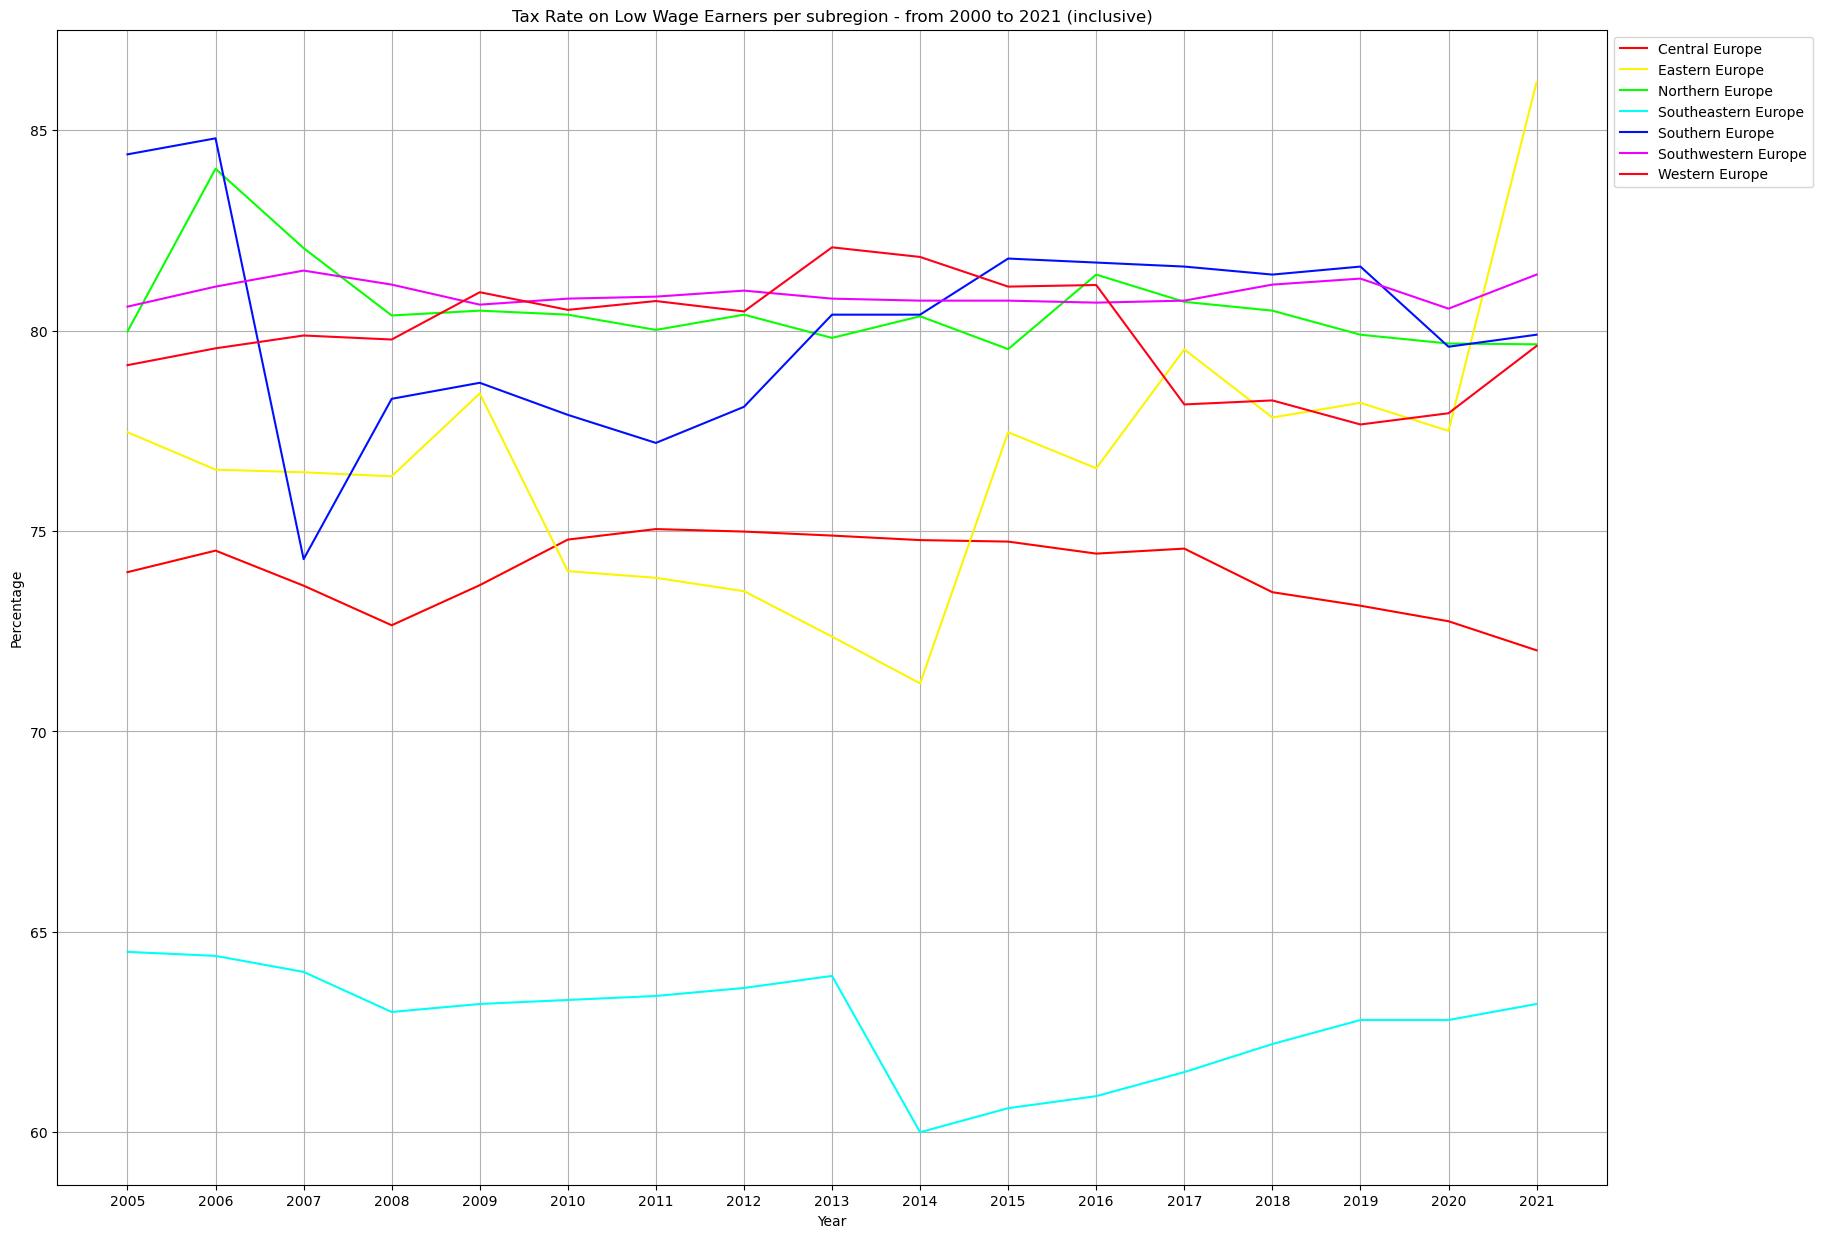

In [19]:
# Plot the tax rate for each country
plt.figure(figsize=(20, 15))

colors = plt.cm.hsv(np.linspace(0, 1, df_eu_regions.shape[0]))
subregions = df_eu_regions['SUBREGION']
years = df_eu_regions.keys()[1:]
years_xticks = [int(year) for year in years]

for i in range(len(subregions)):
    subregion = subregions[i]
    # Plot years to Value
    print()
    plt.plot(years, df_eu_regions.loc[i, years], color=colors[i], label=subregion)

plt.grid()
plt.xticks(years_xticks)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
plt.xlabel('Year') 
plt.ylabel('Percentage')
plt.title("Tax Rate on Low Wage Earners per subregion - from 2000 to 2021 (inclusive)")
plt.show()

In [20]:
# Calculate the mean tax rate for each subregion
df_regions = pd.DataFrame(columns=['Year', 'Subregion', 'Labour Productivity', 'Tax Rate'])
for i in range(len(subregions)):
    tmp_dict = {}
    subregion = subregions[i]
    for year in years:
        tmp_dict[year] = [df_labour.loc[i, year], df_eu_regions.loc[i, year]]
    df_region = pd.DataFrame.from_dict(tmp_dict, orient='index', columns=['Labour Productivity', 'Tax Rate'])
    df_region['Year'] = df_country.index
    df_region['Subregion'] = subregion

    df_regions = pd.concat([df_regions, df_region], axis=0)
df_regions.reset_index(drop=True, inplace=True)
df_regions

,Year,Subregion,Labour Productivity,Tax Rate
0,2005,Central Europe,60.632340,73.9750
1,2006,Central Europe,62.218785,74.5125
2,2007,Central Europe,63.814049,73.6375
3,2008,Central Europe,63.814456,72.6500
4,2009,Central Europe,63.363388,73.6500
...,...,...,...,...
114,2017,Western Europe,72.180878,78.1600
115,2018,Western Europe,73.769587,78.2600
116,2019,Western Europe,74.317394,77.6600
117,2020,Western Europe,75.083567,77.9400


In [21]:
# Look at correlation between labour productivity and tax rate on low wage earners
df_corr_regions = df_regions.groupby(df_regions['Subregion']).corr(numeric_only=True)
df_corr_regions

Labour Productivity  Tax Rate
Subregion                                                             
Central Europe      Labour Productivity             1.000000 -0.315454
                    Tax Rate                       -0.315454  1.000000
Eastern Europe      Labour Productivity             1.000000  0.464297
                    Tax Rate                        0.464297  1.000000
Northern Europe     Labour Productivity             1.000000 -0.480388
                    Tax Rate                       -0.480388  1.000000
Southeastern Europe Labour Productivity             1.000000 -0.404216
                    Tax Rate                       -0.404216  1.000000
Southern Europe     Labour Productivity             1.000000  0.031672
                    Tax Rate                        0.031672  1.000000
Southwestern Europe Labour Productivity             1.000000  0.164181
                    Tax Rate                        0.164181  1.000000
Western Europe      Labour Productivity             1.000000 -0.471014
                    Tax Rate                       -0.471014  1.000000

In [22]:
# Do Granger causality tests on each subregion
for subregion in subregions:
    df_subregion = df_regions[df_regions['Subregion'] == subregion]
    df_subregion = df_subregion[['Labour Productivity', 'Tax Rate']]
    results = grangercausalitytests(df_subregion, maxlag=2, verbose=False)

    # If the p-value is less than 0.05, then the null hypothesis is rejected and there is a Granger Causality
    if results.get(1)[0]['ssr_ftest'][1] < 0.05:
        print('Tax Rate is a predictor variable of Labour Productivity for', subregion)

    results = grangercausalitytests(df_subregion[['Tax Rate', 'Labour Productivity']], maxlag=2, verbose=False)

    # If the p-value is less than 0.05, then the null hypothesis is rejected and there is a Granger Causality
    if results.get(1)[0]['ssr_ftest'][1] < 0.05:
        print('Labour Productivity is a predictor variable of Tax Rate for', subregion)

Labour Productivity is a predictor variable of Tax Rate for Eastern Europe
Labour Productivity is a predictor variable of Tax Rate for Northern Europe
Tax Rate is a predictor variable of Labour Productivity for Southern Europe
